# Qual o próximo hit do Spotify

&nbsp;&nbsp;&nbsp;&nbsp;O objetivo neste *notebook* é criar um modelo de machine learning que preveja a popularidade de uma música no Spotify.

In [404]:
# importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [345]:
# carregamento dos conjuntos de dados
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [347]:
# Informações sobre cada coluna do df
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79800 entries, 0 to 79799
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_unique_id    79800 non-null  int64  
 1   track_id           79800 non-null  object 
 2   artists            79800 non-null  object 
 3   album_name         79800 non-null  object 
 4   track_name         79800 non-null  object 
 5   duration_ms        79800 non-null  int64  
 6   explicit           79800 non-null  bool   
 7   danceability       79800 non-null  float64
 8   energy             79800 non-null  float64
 9   key                79800 non-null  int64  
 10  loudness           79800 non-null  float64
 11  mode               79800 non-null  int64  
 12  speechiness        79800 non-null  float64
 13  acousticness       79800 non-null  float64
 14  instrumentalness   79800 non-null  float64
 15  liveness           79800 non-null  float64
 16  valence            798

&nbsp;&nbsp;&nbsp;&nbsp;Com base nessas informações, é possível concluir que há uma coluna do tipo *boolean*, a qual deve ser transformada em numérica, e 5 colunas do tipo *object*, as quais devem ser codificadas.

In [393]:
# Estatístcas básicas de cada coluna numérica
df_train.describe()

,track_unique_id,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity_target
count,79800.000000,7.980000e+04,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000
mean,57140.494048,2.279022e+05,0.567318,0.641529,5.307043,-8.263741,0.637732,0.084750,0.314979,0.157319,0.213313,0.474267,122.076559,3.902556,0.487845
std,32993.196225,1.050599e+05,0.173110,0.251441,3.562186,5.035504,0.480659,0.105657,0.332512,0.310792,0.190075,0.259010,29.941937,0.434284,0.499855
min,0.000000,1.338600e+04,0.000000,0.000019,0.000000,-49.307000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28450.500000,1.744360e+05,0.456000,0.472000,2.000000,-10.006000,0.000000,0.035900,0.017000,0.000000,0.097900,0.261000,99.081250,4.000000,0.000000
50%,57234.000000,2.128130e+05,0.581000,0.685000,5.000000,-7.012000,1.000000,0.049000,0.169000,0.000041,0.132000,0.464000,122.009000,4.000000,0.000000
75%,85774.250000,2.614260e+05,0.695000,0.854000,8.000000,-5.000000,1.000000,0.084500,0.598000,0.050500,0.273000,0.684000,140.054000,4.000000,1.000000
max,113998.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,222.605000,5.000000,1.000000


&nbsp;&nbsp;&nbsp;&nbsp;Com base nessas estatíscas descritivas, é possível concluir que:
- Algumas variáveis, como `loudness`, `acousticness` e `instrumentalness`, apresentam valores mínimos e máximos dispersos, sugerindo a necessidade de normalização ou padronização antes do treinamento.
- A média de `popularity_target` é aproximadamente 0,49, indicando que há um equilíbrio entre músicas populares e não populares no conjunto.
- A maioria das faixas está em assinatura de tempo 4/4 (`time_signature`).
- Variáveis como duration_ms têm um valor máximo muito alto (5.237.295 ms), o que pode representar um outlier significativo. 

## Limpeza e Tratamento

In [349]:
# Verificar se há duplicatas
duplicatas = df_train[df_train.duplicated(keep='first')]
print(duplicatas)

Empty DataFrame
Columns: [track_unique_id, track_id, artists, album_name, track_name, duration_ms, explicit, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, time_signature, track_genre, popularity_target]
Index: []

[0 rows x 21 columns]


&nbsp;&nbsp;&nbsp;&nbsp;Não há linhas duplicadas no conjunto de dados.

In [351]:
# Verifica se há valores nulos
print(f"{df_train.isnull().sum()}")

track_unique_id      0
track_id             0
artists              0
album_name           0
track_name           0
duration_ms          0
explicit             0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
track_genre          0
popularity_target    0
dtype: int64


In [352]:
# Verifica se há valores nulos
print(f"{df_train.isnull().sum()}")

track_unique_id      0
track_id             0
artists              0
album_name           0
track_name           0
duration_ms          0
explicit             0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
track_genre          0
popularity_target    0
dtype: int64


&nbsp;&nbsp;&nbsp;&nbsp;Nenhuma coluna possui valores nulos nem no conjunto de teste nem no de treinamento.

In [353]:
# Exclusão de colunas
df_sem_col = df_train.drop(columns=['track_id', 'track_name', 'album_name', 'artists'])
df_sem_col 

,track_unique_id,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target
0,41996,211533,False,0.305,0.84900,9,-10.795,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth,0
1,76471,196000,False,0.287,0.19000,7,-12.030,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera,0
2,54809,216506,False,0.583,0.50900,1,-9.661,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm,1
3,16326,218346,False,0.163,0.03680,8,-23.149,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical,0
4,109799,173160,False,0.647,0.92100,2,-7.294,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79795,76820,162613,False,0.554,0.00763,4,-30.566,1,0.0502,0.915000,0.000970,0.2210,0.1560,119.502,4,opera,1
79796,110268,240062,False,0.689,0.55400,9,-8.200,1,0.0759,0.091000,0.914000,0.0867,0.1630,148.002,4,trance,0
79797,103694,136306,False,0.629,0.56000,0,-11.455,0,0.0523,0.595000,0.000000,0.1820,0.8800,118.895,3,soul,0
79798,860,216841,False,0.421,0.10700,6,-15.191,1,0.0335,0.948000,0.000000,0.0881,0.1180,104.218,4,acoustic,1


In [354]:
# Exclusão de colunas
df_sem_col_test = df_test.drop(columns=['track_id', 'track_name', 'album_name', 'artists'])
df_sem_col_test

,track_unique_id,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,113186,440247,False,0.369,0.598,7,-6.984,1,0.0304,0.005110,0.000000,0.176,0.0466,148.014,4,world-music
1,42819,93933,False,0.171,0.997,7,-3.586,1,0.1180,0.005210,0.801000,0.420,0.0294,122.223,4,grindcore
2,59311,213578,False,0.173,0.803,9,-10.071,0,0.1440,0.613000,0.001910,0.195,0.0887,75.564,3,iranian
3,91368,151387,False,0.683,0.511,6,-5.598,1,0.0279,0.406000,0.000197,0.111,0.5980,109.991,3,rock
4,61000,236293,False,0.555,0.941,9,-3.294,0,0.0481,0.484000,0.000000,0.266,0.8130,92.487,4,j-idol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34195,39480,216650,False,0.597,0.980,7,-2.075,1,0.0636,0.004270,0.000035,0.293,0.6330,139.989,4,german
34196,74692,219493,False,0.454,0.367,0,-12.251,1,0.0285,0.137000,0.000029,0.171,0.1420,113.250,4,mpb
34197,53782,165333,True,0.687,0.915,0,-1.342,1,0.0411,0.021000,0.000006,0.151,0.2720,89.962,4,house
34198,41890,293040,False,0.362,0.668,0,-9.578,1,0.0432,0.000406,0.009400,0.131,0.1580,122.234,4,goth


&nbsp;&nbsp;&nbsp;&nbsp;As colunas `track_unique_id`, `track_id`, `track_name`, `artists` e `album_name` não são úteis para prever diretamente a popularidade da música, dado que elas apenas identificam cada música em específico e não caracteríscas das músicas, e podem ser removidas para evitar redundância e excesso de dados textuais não informativos. Contudo, é importante manter a coluna `track_unique_id` para identificação da música na predição; contudo, essa variável não será utilizada no treinamento do modelo.

In [355]:
# DEfinição das colunas numéricas
colunas_numericas = df_sem_col.select_dtypes(include=['number'])

In [356]:
# Checar quais são os outliers
for col in colunas_numericas:
    # Cálculo do IQR para uma coluna
    Q1 = df_sem_col[col].quantile(0.10)
    Q3 = df_sem_col[col].quantile(0.90)
    IQR = Q3 - Q1

    # Definindo limites
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Filtrando outliers
    outliers = df_sem_col[(df_sem_col[col] < limite_inferior) | (df_sem_col[col] > limite_superior)]
    print(col)
    print(outliers)


track_unique_id
Empty DataFrame
Columns: [track_unique_id, duration_ms, explicit, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, time_signature, track_genre, popularity_target]
Index: []
duration_ms
       track_unique_id  duration_ms  explicit  danceability  energy  key  \
223              54657      1664000     False         0.295  0.4830    0   
1191             13903       641584     False         0.891  0.5110    1   
1657             11037       673269     False         0.251  0.1700    2   
1706             65475      3340672     False         0.719  0.4660    3   
1760             72262      1003746      True         0.277  0.9100    7   
...                ...          ...       ...           ...     ...  ...   
78978            34620       655760     False         0.297  0.6550    9   
79012            93714       625173     False         0.318  0.0981    1   
79122            34911      1749173     False     

&nbsp;&nbsp;&nbsp;&nbsp;A iteração `for` busca outliers em colunas numéricas usando o método do intervalo interquartil (IQR), mas com quantis 0.10 e 0.90. Utilizar limites mais amplos, como 0.10 e 0.90, faz com que detecte-se outliers mais extremos, sem descartar muitos dados.

&nbsp;&nbsp;&nbsp;&nbsp;As colunas que possuem valores acima dos 90% ou abaixo dos 10% são:
* `time_signature`
* `duration_ms`
* `loudness`
* `speechiness`
* `liveness`

In [357]:
# Colunas que possuem outliers
cols_outliers = ['time_signature', 'duration_ms', 'loudness', 'speechiness', 'liveness']

In [358]:
def winsorize(df, column):
    Q1 = df[column].quantile(0.10)
    Q3 = df[column].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Substituir outliers pelos limites
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df

# Lista de colunas que possuem outliers
cols_outliers = ['time_signature', 'duration_ms', 'loudness', 'speechiness', 'liveness']

# Aplicar Winsorization em cada coluna especificada
for col in cols_outliers:
    df_sem_outliers = winsorize(df_sem_col, col)

&nbsp;&nbsp;&nbsp;&nbsp;A função `winsorize` realiza do tratamento dessses outliers, os valores que estão abaixo do limite inferior são substituídos pelo limite inferior, e os valores que estão acima do limite superior são substituídos pelo limite superior.

In [394]:
df_sem_outliers.describe()

,track_unique_id,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity_target
count,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.0,79800.000000
mean,57140.494048,0.357867,0.575958,0.641522,0.482458,0.629281,0.637732,0.080055,0.314979,0.157319,0.213190,0.474267,0.548400,4.0,0.487845
std,32993.196225,0.141701,0.175746,0.251446,0.323835,0.142570,0.480659,0.078296,0.332512,0.310792,0.189587,0.259010,0.134507,0.0,0.499855
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,0.000000
25%,28450.500000,0.270737,0.462944,0.471990,0.181818,0.577985,0.000000,0.035900,0.017000,0.000000,0.097900,0.261000,0.445099,4.0,0.000000
50%,57234.000000,0.335251,0.589848,0.684994,0.454545,0.664896,1.000000,0.049000,0.169000,0.000041,0.132000,0.464000,0.548096,4.0,0.000000
75%,85774.250000,0.416973,0.705584,0.853997,0.727273,0.723301,1.000000,0.084500,0.598000,0.050500,0.273000,0.684000,0.629159,4.0,1.000000
max,113998.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.394400,0.996000,1.000000,0.955750,0.995000,1.000000,4.0,1.000000


&nbsp;&nbsp;&nbsp;&nbsp;As colunas 'duration_ms', 'danceability', 'energy', 'key', 'loudness' e 'tempo' possuiem, de acordo com as estísticas descritivas, valores de mínimo e máximo distantes e com escalas diferentes entre si; portanto, faz-se necessário realizar a normalização delas.

In [397]:
# Seleciona as colunas para normalizar
colunas_a_normalizar = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'tempo']

# Inicializando o MinMaxScaler
scaler = MinMaxScaler()

# Aplica o MinMaxScaler nas colunas numéricas
df_sem_outliers[colunas_a_normalizar] = scaler.fit_transform(df_sem_outliers[colunas_a_normalizar])


In [398]:
df_sem_outliers.describe()

,track_unique_id,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity_target
count,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.0,79800.000000
mean,57140.494048,0.357867,0.575958,0.641522,0.482458,0.629281,0.637732,0.080055,0.314979,0.157319,0.213190,0.474267,0.548400,4.0,0.487845
std,32993.196225,0.141701,0.175746,0.251446,0.323835,0.142570,0.480659,0.078296,0.332512,0.310792,0.189587,0.259010,0.134507,0.0,0.499855
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,0.000000
25%,28450.500000,0.270737,0.462944,0.471990,0.181818,0.577985,0.000000,0.035900,0.017000,0.000000,0.097900,0.261000,0.445099,4.0,0.000000
50%,57234.000000,0.335251,0.589848,0.684994,0.454545,0.664896,1.000000,0.049000,0.169000,0.000041,0.132000,0.464000,0.548096,4.0,0.000000
75%,85774.250000,0.416973,0.705584,0.853997,0.727273,0.723301,1.000000,0.084500,0.598000,0.050500,0.273000,0.684000,0.629159,4.0,1.000000
max,113998.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.394400,0.996000,1.000000,0.955750,0.995000,1.000000,4.0,1.000000


&nbsp;&nbsp;&nbsp;&nbsp;Conforme pode ser visto nas estatíscas acima, as colunas agora possuem a mesma escala, o que é benéfico para o treinamento do modelo; dado que, se as *features* estiverem em escalas diferentes, algumas podem dominar o comportamento do modelo, enquanto outras serão negligenciadas. Essa padrnização também será feita nos dados de teste:

In [361]:
# Aplica o MinMaxScaler nas colunas numéricas
df_sem_col_test[colunas_a_normalizar] = scaler.fit_transform(df_sem_col_test[colunas_a_normalizar])
df_sem_col_test

,track_unique_id,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,113186,0.093070,False,0.376531,0.598,0.636364,0.828956,1,0.0304,0.005110,0.000000,0.176,0.0466,0.608180,4,world-music
1,42819,0.019858,False,0.174490,0.997,0.636364,0.895160,1,0.1180,0.005210,0.801000,0.420,0.0294,0.502206,4,grindcore
2,59311,0.045151,False,0.176531,0.803,0.818182,0.768811,0,0.1440,0.613000,0.001910,0.195,0.0887,0.310488,3,iranian
3,91368,0.032004,False,0.696939,0.511,0.545455,0.855960,1,0.0279,0.406000,0.000197,0.111,0.5980,0.451946,3,rock
4,61000,0.049953,False,0.566327,0.941,0.818182,0.900849,0,0.0481,0.484000,0.000000,0.266,0.8130,0.380023,4,j-idol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34195,39480,0.045800,False,0.609184,0.980,0.636364,0.924600,1,0.0636,0.004270,0.000035,0.293,0.6330,0.575206,4,german
34196,74692,0.046401,False,0.463265,0.367,0.000000,0.726338,1,0.0285,0.137000,0.000029,0.171,0.1420,0.465337,4,mpb
34197,53782,0.034952,True,0.701020,0.915,0.000000,0.938881,1,0.0411,0.021000,0.000006,0.151,0.2720,0.369648,4,house
34198,41890,0.061950,False,0.369388,0.668,0.000000,0.778416,1,0.0432,0.000406,0.009400,0.131,0.1580,0.502252,4,goth


In [362]:
df_sem_outliers.describe()

,track_unique_id,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity_target
count,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.0,79800.000000
mean,57140.494048,0.357867,0.575958,0.641522,0.482458,0.629281,0.637732,0.080055,0.314979,0.157319,0.213190,0.474267,0.548400,4.0,0.487845
std,32993.196225,0.141701,0.175746,0.251446,0.323835,0.142570,0.480659,0.078296,0.332512,0.310792,0.189587,0.259010,0.134507,0.0,0.499855
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,0.000000
25%,28450.500000,0.270737,0.462944,0.471990,0.181818,0.577985,0.000000,0.035900,0.017000,0.000000,0.097900,0.261000,0.445099,4.0,0.000000
50%,57234.000000,0.335251,0.589848,0.684994,0.454545,0.664896,1.000000,0.049000,0.169000,0.000041,0.132000,0.464000,0.548096,4.0,0.000000
75%,85774.250000,0.416973,0.705584,0.853997,0.727273,0.723301,1.000000,0.084500,0.598000,0.050500,0.273000,0.684000,0.629159,4.0,1.000000
max,113998.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.394400,0.996000,1.000000,0.955750,0.995000,1.000000,4.0,1.000000


&nbsp;&nbsp;&nbsp;&nbsp;Conforme as estatíscas atualizadas, é visível que a escala agora está padronizada.

In [363]:
df_sem_time = df_sem_outliers.drop(columns='time_signature')

&nbsp;&nbsp;&nbsp;&nbsp;A coluna `time_signature` sem os outliers apresenta apenas o valor "4"; portanto, ela não faria diferença na predição do modelo e pode ser excluída.

## Codificação de Variáveis Categóricas

In [364]:
# Codificação One-Hot para variáveis categóricas
encoder = OneHotEncoder(sparse_output=False)
encoded_genres = pd.DataFrame(encoder.fit_transform(df_sem_outliers[['track_genre']]), 
                              columns=encoder.get_feature_names_out(['track_genre']))
df_encoded = pd.concat([df_sem_time.drop(columns=['track_genre']), encoded_genres], axis=1)
df_encoded

,track_unique_id,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
0,41996,0.333100,False,0.309645,0.848997,0.818182,0.555081,1,0.0549,0.000058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,76471,0.306987,False,0.291371,0.189984,0.636364,0.519231,0,0.0370,0.930000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,54809,0.341460,False,0.591878,0.508990,0.090909,0.588000,1,0.0362,0.777000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16326,0.344553,False,0.165482,0.036781,0.727273,0.196464,1,0.0472,0.991000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,109799,0.268592,False,0.656853,0.920998,0.181818,0.656710,1,0.1850,0.000939,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79795,76820,0.250861,False,0.562437,0.007611,0.363636,0.000000,1,0.0502,0.915000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79796,110268,0.381059,False,0.699492,0.553991,0.818182,0.630410,1,0.0759,0.091000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
79797,103694,0.206637,False,0.638579,0.559991,0.000000,0.535923,0,0.0523,0.595000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79798,860,0.342023,False,0.427411,0.106983,0.545455,0.427472,1,0.0335,0.948000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


&nbsp;&nbsp;&nbsp;&nbsp;Para a coluna `track_genre`, o método esolhido foi o One Hot Enconding, o qual transforma variáveis categóricas em colunas binárias. A codificação One-Hot é importante porque os modelos de aprendizado de máquina precisam trabalhar com dados numéricos. Se fosse atribuído um número inteiro a cada gênero (por exemplo, "Rock" = 1, "Pop" = 2, "Jazz" = 3), o modelo poderia interpretar erroneamente essas categorias como ordinais, ou seja, assumindo uma relação entre elas (como se 3 fosse maior ou "melhor" que 1). O One-Hot Encoding resolve esse problema ao representar cada categoria de forma independente. O mesmo processo será feito para os dados de teste:

In [387]:
# Codificação One-Hot para variáveis categóricas
encoder = OneHotEncoder(sparse_output=False)
encoded_genres = pd.DataFrame(encoder.fit_transform(df_sem_col_test[['track_genre']]), 
                              columns=encoder.get_feature_names_out(['track_genre']))
df_encoded_test = pd.concat([df_sem_col_test.drop(columns=['track_genre']), encoded_genres], axis=1)
df_encoded_test

,track_unique_id,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
0,113186,0.093070,False,0.376531,0.598,0.636364,0.828956,1,0.0304,0.005110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,42819,0.019858,False,0.174490,0.997,0.636364,0.895160,1,0.1180,0.005210,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59311,0.045151,False,0.176531,0.803,0.818182,0.768811,0,0.1440,0.613000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91368,0.032004,False,0.696939,0.511,0.545455,0.855960,1,0.0279,0.406000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,61000,0.049953,False,0.566327,0.941,0.818182,0.900849,0,0.0481,0.484000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34195,39480,0.045800,False,0.609184,0.980,0.636364,0.924600,1,0.0636,0.004270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34196,74692,0.046401,False,0.463265,0.367,0.000000,0.726338,1,0.0285,0.137000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34197,53782,0.034952,True,0.701020,0.915,0.000000,0.938881,1,0.0411,0.021000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34198,41890,0.061950,False,0.369388,0.668,0.000000,0.778416,1,0.0432,0.000406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [366]:
df_encoded['explicit'] = df_encoded['explicit'].astype(int)

In [389]:
df_encoded_test['explicit'] = df_encoded_test['explicit'].astype(int)

&nbsp;&nbsp;&nbsp;&nbsp;A coluna `explicit` continha os valores `True` e `False`, que foram substituidos respectivamente por 1 e 0 para que o modelo consiga utilizar essa variável.

## Exploração e Visualização dos Dados

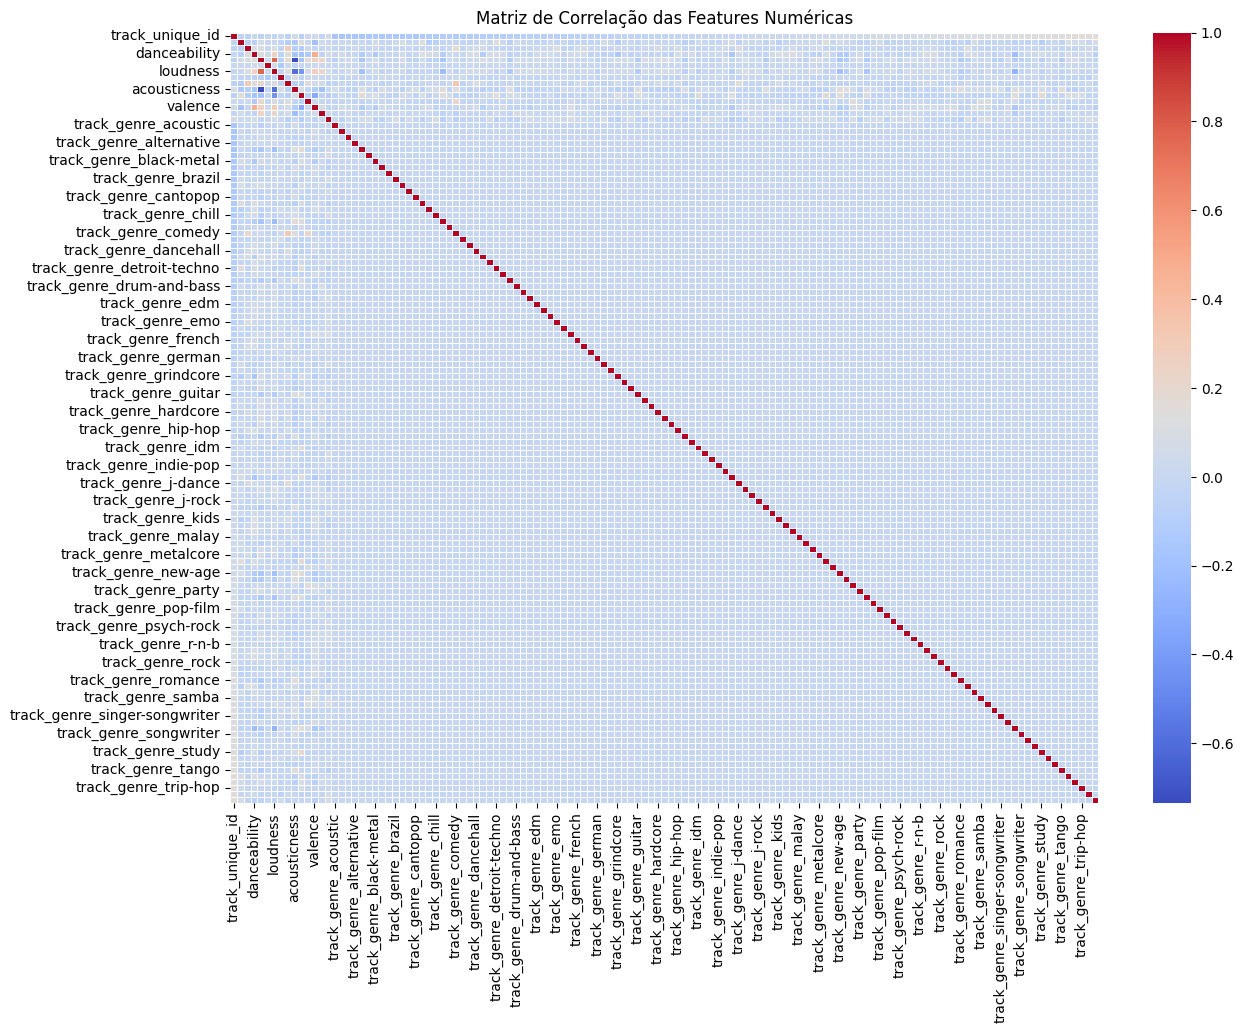

In [368]:
# Definindo o tamanho da figura para melhor visualização
plt.figure(figsize=(14,10))

# Criando um heatmap da matriz de correlação
sns.heatmap(df_encoded.corr(), annot=False, cmap='coolwarm', linewidths=0.5)

# Exibir o gráfico
plt.title("Matriz de Correlação das Features Numéricas")
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;A matriz de correlação é uma tabela que mostra os coeficientes de correlação entre várias variáveis. A correlação mede a força e a direção da relação linear entre duas variáveis numéricas, e seu valor varia de -1 a 1. A maior parte da matriz plotada para as variáveis está em um tom azul claro, sugerindo que não há muitas correlações fortes (nem positivas nem negativas) entre as variáveis. No entanto, algumas regiões pequenas mostram correlações fracas (com pontos ligeiramente mais vermelhos ou azuis), os quais podem ser melhor observados na matriz abaixo:

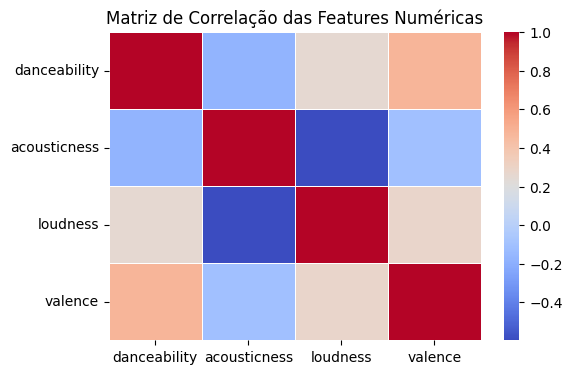

In [369]:
df_correlacao = df_encoded[['danceability', 'acousticness', 'loudness', 'valence']]

plt.figure(figsize=(6,4))

# Criando um heatmap da matriz de correlação
sns.heatmap(df_correlacao.corr(), annot=False, cmap='coolwarm', linewidths=0.5)

# Exibir o gráfico
plt.title("Matriz de Correlação das Features Numéricas")
plt.show()


&nbsp;&nbsp;&nbsp;&nbsp;Na matriz acima é visível que:
* `Acousticness` tem correlação negativa forte com `loudness`, o que faz sentido, já que músicas acústicas tendem a ser mais suaves.
* `Danceability` tem uma leve correlação positiva com `valence`, sugerindo que músicas mais dançáveis são geralmente mais alegres.
* Poucas correlações muito fortes além dessas, sugerindo que essas características variam independentemente em muitos casos.

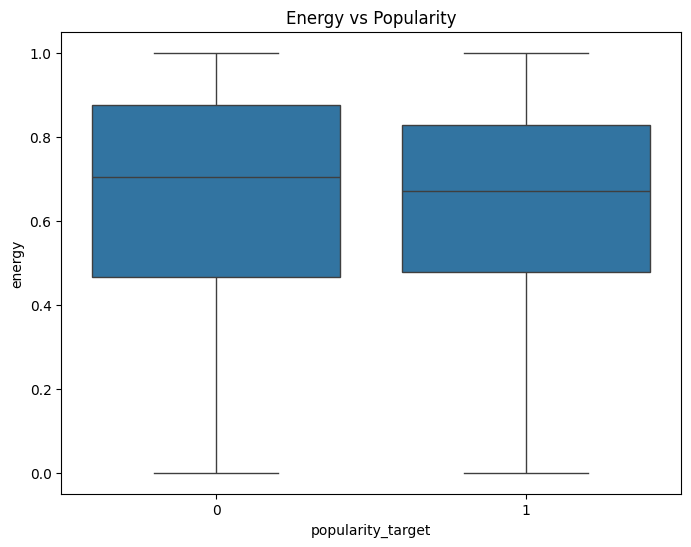

In [370]:
# Relação entre 'energy' e 'popularity_target'
plt.figure(figsize=(8, 6))
sns.boxplot(x='popularity_target', y='energy', data=df_encoded)
plt.title('Energy vs Popularity')
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;Com o gráfico acima, pode-se concluir que a diferença entre a energia das faixas populares e não populares parece ser mínima, sugerindo que `energy` não é um fator distintivo claro para determinar a popularidade, dado que as distribuições são bastante semelhantes em ambos os casos.

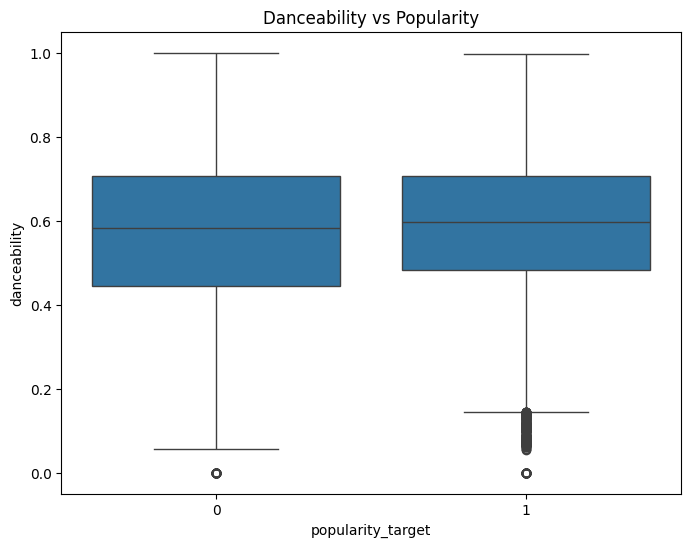

In [371]:
# Relação entre 'danceability' e 'popularity_target'
plt.figure(figsize=(8, 6))
sns.boxplot(x='popularity_target', y='danceability', data=df_encoded)
plt.title('Danceability vs Popularity')
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;O gráfico acima sugere que, embora `danceability` seja uma característica relevante tanto para músicas populares quanto para as não populares, ela não parece ser um fator decisivo na distinção entre essas categorias.

## Hipóteses

Portanto, com base nos gráficos apresentados, algumas das hipóteses que podem ser feitas são:

1. `energy` não é um fator distintivo claro para determinar a popularidade.

2. `danceability` não é um fator decisivo na distinção entre ser ou não uma música popular.

3. `acousticness` tem correlação negativa com `loudness`.

4. `danceability` tem uma leve correlação positiva com `valence`, sugerindo que músicas mais dançáveis são geralmente mais alegres.


## Seleção de Features

&nbsp;&nbsp;&nbsp;&nbsp;A análise de correlação mostra que as variáveis numéricas têm correlação relativamente baixa com o alvo "popularity_target", sugerindo que a combinação das *features* pode ser mais importante do que a análise individual. Ademais, algumas das *features* (`track_unique_id`, `track_id`, `track_name`, `artists` e `album_name`) já foram removidas por terem baixa relevância e possuírem valores redundantes.

&nbsp;&nbsp;&nbsp;&nbsp;Portanto, usar-se-á as demais *features* disponíveis para o treinamento do modelo e, caso o desempenho seja ruim, pode-se testar retirar as features de menor importância segundo o gráfico abaixo.

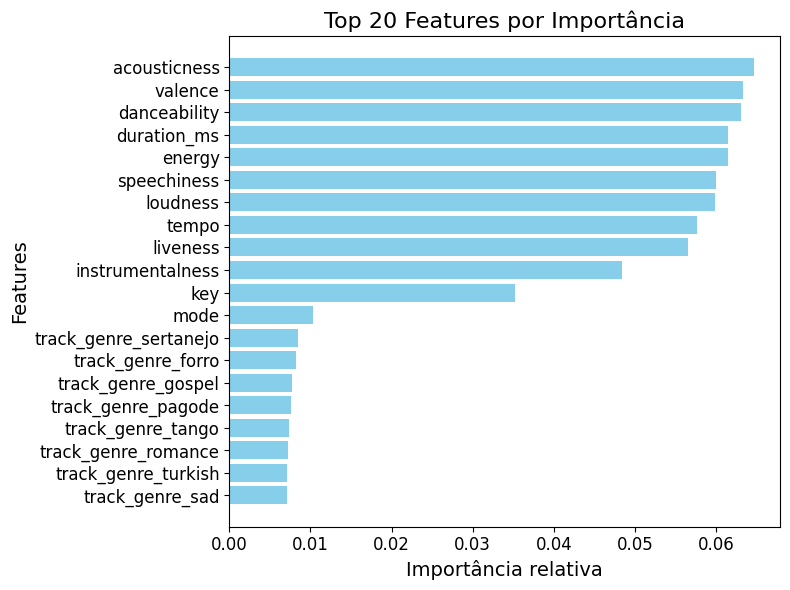

In [400]:
X = df_encoded.drop(columns=['popularity_target', 'track_unique_id'])
y = df_encoded['popularity_target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Importância de cada feature
feature_importances = rf_model.feature_importances_
features = X.columns

# Gera uma relação entre as features e sua importância no resultado
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Mostra apenas as 20 features mais importantes
top_20_features = importance_df.head(20)

# Gráfico para visualização das importâncias das 20 features mais importantes
plt.figure(figsize=(8, 6))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importância relativa', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top 20 Features por Importância', fontsize=16)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [373]:
# Seleção das features
features = df_encoded.drop(columns=['popularity_target', 'track_unique_id']).columns
target = ['popularity_target']

## Construção e Avaliação do Modelo

In [374]:
# Separação entre features e alvo
X = df_encoded[features]
y = df_encoded[target]

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [408]:
# Função para calcular métricas de avaliação dos modelos
def metricas(model):
   
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"A acurácia do modelo Random Forest é: {accuracy:.2f}")

    precision = precision_score(y_test, y_pred)
    print(f"A precisãa do modelo Random Forest é: {precision:.2f}")

    recall = recall_score(y_test, y_pred)
    print(f"O recall do modelo Random Forest é: {recall:.2f}")

    f1score = f1_score(y_test, y_pred)
    print(f"O f1-score do modelo Random Forest é: {f1score:.2f}")
    
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"O roc_auc_score do modelo Random Forest é: {roc_auc:.2f}")

    logloss = log_loss(y_test, y_pred)
    print(f"O log loss do modelo Random Forest é: {logloss:.2f}")

    # Plotar a matriz de confusão normalizada
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='.2', cmap='Blues')
    plt.title('Matriz de Confusão Normalizada')
    plt.ylabel('Classe Real')
    plt.xlabel('Classe Predita')
    plt.show()

In [376]:
model_rf = RandomForestClassifier(random_state=42, n_estimators=200)
model_rf.fit(X_train, y_train)

c:\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


A acurácia do modelo Random Forest é: 0.84
A precisãa do modelo Random Forest é: 0.83
O recall do modelo Random Forest é: 0.84


A acurácia do modelo Random Forest é: 0.89
A precisãa do modelo Random Forest é: 0.89
O recall do modelo Random Forest é: 0.89
O f1-score do modelo Random Forest é: 0.89
O roc_auc_score do modelo Random Forest é: 0.89
O log loss do modelo Random Forest é: 3.96


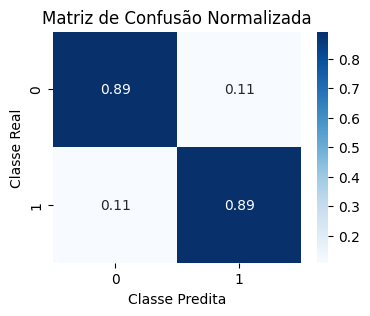

In [409]:
metricas(model_rf)

- A acurácia representa a proporção de previsões corretas em relação ao total de previsões feitas. No caso, o modelo tem uma acurácia de 89%, o que significa que, de todas as classificações feitas, 89% estavam corretas.
- A precisão mede a proporção de verdadeiros positivos em relação a todas as previsões positivas. Uma precisão de 89% indica que, das instâncias previstas como positivas, 89% estavam corretas.
- O recall mede a capacidade do modelo de identificar corretamente as instâncias positivas, ou seja, a proporção de verdadeiros positivos em relação a todos os exemplos que são realmente positivos. Um valor de 89% indica que o modelo conseguiu capturar 89% de todas as instâncias positivas reais.
- O F1-score é a média harmônica entre precisão e recall, e é útil quando há um desbalanceamento entre as classes. Como tanto a precisão quanto o recall são iguais a 0.89, o F1-score também é 0.89, indicando um equilíbrio entre a capacidade de prever corretamente as instâncias positivas e evitar falsos positivos.
- O ROC AUC Score mede a capacidade do modelo de distinguir entre classes positivas e negativas. Um valor de 0.89 indica que, em 89% das vezes, o modelo será capaz de distinguir corretamente entre uma instância positiva e uma negativa.
- O log loss (erro logarítmico) mede a incerteza das previsões de probabilidades. Ele penaliza previsões que estão muito erradas, e quanto menor esse valor, melhor. Um valor de 3.96 sugere que, apesar de o modelo estar obtendo boas métricas de desempenho, ele pode estar cometendo alguns erros graves em termos de incerteza nas previsões.

&nbsp;&nbsp;&nbsp;&nbsp;Portanto, o modelo apresenta um bom desempenho com valores altos de acurácia, precisão, recall, F1-score e ROC AUC. No entanto, o log loss elevado pode indicar que o modelo precisa ser ajustado para lidar melhor com a incerteza em suas previsões.

## Finetuning de Hiperparâmetros

&nbsp;&nbsp;&nbsp;&nbsp;Tuning de hiperparâmetros é o processo de ajustar os parâmetros de controle de um modelo de aprendizado de máquina para melhorar seu desempenho. Hiperparâmetros são configurações que não são aprendidas pelo modelo durante o treinamento, como a profundidade máxima de uma árvore de decisão e o número de árvores em um Random Forest. O objetivo do tuning é encontrar a melhor combinação de valores que maximize a performance do modelo.

&nbsp;&nbsp;&nbsp;&nbsp;Nesse cenário, o Grid Search é uma técnica para otimizar hiperparâmetros que testa todas as possíveis combinações de hiperparâmetros de um modelo dentro de um conjunto pré-definido, avaliando o desempenho de cada combinação. Ao final, ele seleciona a que gera os melhores resultados. Dessa forma, a função `optimize_model` abaixo aplica o Grid Search para o modelo passado como parâmetro.

In [377]:
# Função para realizar a busca de hiperparâmetros
def optimize_model(model, param_grid, X_train, y_train):
    # Cria um objeto GridSearchCV para realizar a busca em grade de hiperparâmetros
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

    # Treina o modelo utilizando os dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprime os melhores hiperparâmetros encontrados para o modelo
    print(f"Melhores parâmetros para {model.__class__.__name__}: {grid_search.best_params_}")
    
    # Retorna o modelo ajustado com os melhores hiperparâmetros
    return grid_search.best_estimator_

In [378]:
# Parâmetros para otimização de Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Aplicar a otimização de hiperparâmetros para cada modelo
optimize_model(RandomForestClassifier(random_state=42), param_grid_rf, X_train, y_train)

&nbsp;&nbsp;&nbsp;&nbsp;A função acima retorna que os melhores parâmetros são: `max_depth= None, min_samples_leaf= 1, min_samples_split= 5, n_estimators= 300`, os quais são aplicados abaixo:

In [379]:
# Treinamento do mdelo com os parâmetros dados pelo Grid Search
rf = RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split= 5, n_estimators= 300)
rf.fit(X_train, y_train)

c:\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(min_samples_split=5, n_estimators=300)

A acurácia do modelo Random Forest é: 0.89
A precisãa do modelo Random Forest é: 0.88
O recall do modelo Random Forest é: 0.89
O f1-score do modelo Random Forest é: 0.88
O roc_auc_score do modelo Random Forest é: 0.89
O log loss do modelo Random Forest é: 4.13


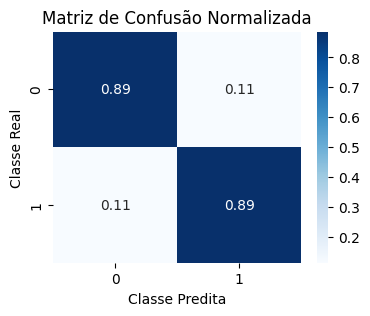

In [410]:
# Avaliação do modelo com ajuste de hiperparâmetros
metricas(rf)

- A acurácia continua indicando que 89% das previsões do modelo estão corretas, o que reflete um bom desempenho geral.
- A precisão agora é ligeiramente menor (88%), o que significa que, das instâncias previstas como positivas, 88% estão corretas. Isso sugere que o modelo faz previsões um pouco menos precisas para as instâncias positivas em comparação com antes.
- O recall se mantém em 89%, o que indica que o modelo ainda está capturando 89% das instâncias positivas reais. Ou seja, ele continua bom em identificar corretamente as classes positivas.
- O F1-score, que combina precisão e recall, está agora em 88%. Isso mostra que há um leve impacto no equilíbrio entre a capacidade de prever corretamente as instâncias positivas e evitar falsos positivos, devido à redução da precisão.
- O ROC AUC continua alto, com 0.89, indicando que o modelo é capaz de distinguir bem entre classes positivas e negativas na maioria dos casos.
- O log loss aumentou para 4.13, o que significa que o modelo está enfrentando uma maior incerteza em suas previsões probabilísticas. Isso sugere que, embora o modelo esteja obtendo boas classificações, a confiança em algumas previsões está sendo penalizada.

&nbsp;&nbsp;&nbsp;&nbsp;Portanto, o modelo continua com um desempenho geral sólido (com alta acurácia, recall e ROC AUC), mas a leve queda na precisão e o aumento do log loss podem indicar uma necessidade de ajustes finos nos hiperparâmetros para melhorar a confiança nas previsões.

## Teste

&nbsp;&nbsp;&nbsp;&nbsp;O trecho de código abaixo realiza as predições para os dados no conjunto de testes e cria o arquivo .csv com essas predições.

In [390]:
# Fazendo as previsões
y_pred = rf.predict(df_encoded_test[features])

# Criando um DataFrame com os IDs das músicas e as previsões
submission_df = pd.DataFrame({
    'track_unique_id': df_encoded_test['track_unique_id'],
    'popularity_target': y_pred
})

# Salvando o DataFrame em um arquivo CSV
submission_df.to_csv('submission.csv', index=False)
